## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from keras.models import Model
import os
import io
from tqdm import tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
import math
import sklearn
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

## Classes to handle dataset images

In [2]:
class DatasetHandler:
    def __init__(self,
                 model_path,
                 dataset,
                 img_width=200,
                 img_height=200,
                 batch_size=32):
        
        self.model_path = model_path
        self.dataset = dataset
        self.img_width = img_width
        self.img_height = img_height
        self.obstacle_images = []
        self.no_obstacle_images = []
        self.sdv_images = []
        self._update_image_lists = False
        self.batch_size = batch_size
            
        # Will be determined while reading all images from dataset
        self.num_obstacles = 0
        self.num_no_obstacles = 0
        self.num_sdvs = 0
        self.num_images = 0
            
        (self.obstacle_image_names,
        self.num_obstacles) = self._get_all_dataset_image_names(self.dataset, 'obstacle')
        (self.no_obstacle_image_names,
        self.num_no_obstacles) = self._get_all_dataset_image_names(self.dataset, 'no_obstacle')
                            
    def _get_all_dataset_image_names(self, dataset, class_name):
        class_dataset = os.path.join(dataset, class_name)
        image_names = os.listdir(class_dataset)
        image_paths = [os.path.join(class_dataset, image_name) for image_name in image_names]
        
        return image_paths, len(image_paths)
            
    def _get_image(self, imname):
        imrgb = cv2.imread(imname)
        im = cv2.cvtColor(imrgb, cv2.COLOR_BGR2GRAY) 
        
        return im
    
    def get_metrics(self, model, color_mode='rgb'):
        datagen = ImageDataGenerator(rescale=1./255)

        val_generator = datagen.flow_from_directory(
            self.dataset,
            target_size=(self.img_width, self.img_height),
            color_mode=color_mode,
            batch_size=self.batch_size,
            shuffle=False,
            class_mode='binary'
        )

        return model.evaluate_generator(val_generator, verbose=1)
        
    def get_predictions(self, model, color_mode='rgb'):
        datagen = ImageDataGenerator(rescale=1./255)

        val_generator = datagen.flow_from_directory(
            self.dataset,
            target_size=(self.img_width, self.img_height),
            color_mode=color_mode,
            batch_size=self.batch_size,
            shuffle=False,
            class_mode='binary'
        )

        ret = model.predict_generator(val_generator, verbose=1)
        filenames = val_generator.filenames

        return ret, filenames
        
    def print_model_metrics(self, model, color_mode):
        metrics = self.get_metrics(model, color_mode)

        for name, value in zip(model.metrics_names, metrics):
            print(name, ': ', value)
            
    # Compute and plot multi-class confusion-matrix
    def plot_cm(self, model_path, labels, predictions):
        cm = confusion_matrix(labels, predictions > 0.5) 
        print(f'cm: {cm}')
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title('Confusion matrix')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')        

## Main

Found 1622 images belonging to 2 classes.


/home/drevital/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


51/51 [==============================] - 10s 181ms/step - loss: 0.8015 - auc: 0.9975 - recall: 0.9655 - specifity: 0.9988
loss :  0.8015354871749878
auc :  0.9974663257598877
recall :  0.9654747247695923
specifity :  0.9987669587135315
Found 1622 images belonging to 2 classes.


/home/drevital/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


51/51 [==============================] - 9s 172ms/step
cm: [[807   4]
 [ 28 783]]


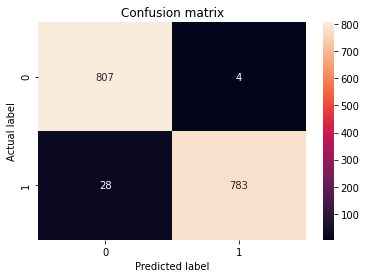

In [3]:
# -- Variables --
model_path = '/home/drevital/cs_video_processor/models/gg_2_const_decay_by_loss_x_2'
dataset = '/home/drevital/obstacles_classification_datasets/gg_2_const/eval'
model_name = model_path.split('/')[-1]
color_mode = 'rgb'

# -- Run the Evaluation --
model = tf.keras.models.load_model(model_path)
handler = DatasetHandler(model_path, dataset)

# -- Print metrics
metrics = handler.print_model_metrics(model, color_mode)
labels = np.array([0]*handler.num_no_obstacles\
                + [1]*handler.num_obstacles)

# -- Predict with the model
predictions, filenames = handler.get_predictions(model, color_mode=color_mode)

# -- Print confision-matrix
handler.plot_cm(model_path, labels, predictions)